# Unified Model with Multiple Strategic Agents: Real Data Example

### Different alpha weights

James Yu, 23 February 2025

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import us
np.set_printoptions(suppress=True)

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, tol = 300):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    max_distances = defaultdict(list)
    counter = 0
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        cd_K = [np.max(np.abs(K_t[l] - K_new[l])) for l in range(L)]
        cd_k = [np.max(np.abs(k_t[l] - k_new[l])) for l in range(L)]
        cd_kappa = [np.max(np.abs(kappa_t[l] - kappa_new[l])) for l in range(L)]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new
        historical_K.insert(0, K_t)
        historical_k.insert(0, k_t)
        historical_kappa.insert(0, kappa_t)
        for l in range(L):
            max_distances[(l+1, "K")].append(cd_K[l])
            max_distances[(l+1, "k")].append(cd_k[l])
            max_distances[(l+1, "kappa")].append(cd_kappa[l])
        counter += 1
        if sum(cd_K + cd_k + cd_kappa) == 0 or counter > tol:
            return max_distances, historical_K, historical_k, historical_kappa

In [5]:
def optimal(X_init, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c, infinite = True):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(lambda: 0)
    i = 0
    while [i < len(historical_K), True][infinite]:
        K_t = historical_K[[i, 0][infinite]]
        k_t = historical_k[[i, 0][infinite]]
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n)
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if infinite == True and np.max(X_t[l] - X_new) == 0 and l == L - 1:
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

In [6]:
def run_simulation(A, X_0_1, b2, a1, a2):
    X_0 = [X_0_1, X_0_1 - b2]
    delta = 0.9 # discount rate
    c_cost = 1 # message cost
    n = X_0_1.shape[0] # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [c_cost * np.identity(n), c_cost * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [a1 * np.identity(n), a2 * np.identity(n)] # B^l = a_l I_n
    x = [0, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
    xs, rs, payoffs = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)
    return xs[0], rs, payoffs
    #print(xs[0][-1])
    

In [7]:
network_matrix = pd.read_csv("state_net_adjacency.csv")

In [8]:
state_label_list = list(network_matrix.columns[1:])
state_name_list = []
for state_label in state_label_list:
    if state_label == "DC":
        state_name_list.append("District of Columbia")
    else:
        state_name_list.append(us.states.lookup(state_label).name)

In [9]:
initial_x_data = pd.read_csv("YCOM7_publicdata.csv")

In [10]:
state_opinion_map = {}
for row in initial_x_data.iterrows():
    if row[1]["geoname"] in state_name_list:
        state_opinion_map[row[1]["geoname"]] = row[1]["consensusOppose"]

state_opinion_map

{'Alabama': 27.95,
 'Alaska': 24.83,
 'Arizona': 25.04,
 'Arkansas': 28.93,
 'California': 20.41,
 'Colorado': 23.02,
 'Connecticut': 21.35,
 'Delaware': 23.52,
 'District of Columbia': 15.46,
 'Florida': 24.26,
 'Georgia': 23.67,
 'Hawaii': 21.37,
 'Idaho': 29.87,
 'Illinois': 22.39,
 'Indiana': 29.06,
 'Iowa': 27.53,
 'Kansas': 27.95,
 'Kentucky': 30.16,
 'Louisiana': 25.9,
 'Maine': 24.72,
 'Maryland': 19.4,
 'Massachusetts': 19.85,
 'Michigan': 24.59,
 'Minnesota': 23.85,
 'Mississippi': 26.22,
 'Missouri': 27.57,
 'Montana': 28.45,
 'Nebraska': 28.35,
 'Nevada': 25.28,
 'New Hampshire': 24.29,
 'New Jersey': 20.85,
 'New Mexico': 25.35,
 'New York': 20.08,
 'North Carolina': 24.11,
 'North Dakota': 32.61,
 'Ohio': 26.76,
 'Oklahoma': 30.14,
 'Oregon': 22.67,
 'Pennsylvania': 24.49,
 'Rhode Island': 23.9,
 'South Carolina': 26.28,
 'South Dakota': 29.46,
 'Tennessee': 28.29,
 'Texas': 24.77,
 'Utah': 28.69,
 'Vermont': 22.07,
 'Virginia': 22.33,
 'Washington': 21.7,
 'West Virginia

In [11]:
X_0_1_data = []
# iterate over the states as ordered in the matrix 
# to ensure the initial opinions have the same order
for state_label in state_label_list:
    if state_label == "DC":
        state_name = "District of Columbia"
    else:
        state_name = us.states.lookup(state_label).name
    X_0_1_data.append(state_opinion_map[state_name])

print(X_0_1_data) # the initial opinions

[24.83, 27.95, 28.93, 25.04, 20.41, 23.02, 21.35, 15.46, 23.52, 24.26, 23.67, 21.37, 27.53, 29.87, 22.39, 29.06, 27.95, 30.16, 25.9, 19.85, 19.4, 24.72, 24.59, 23.85, 27.57, 26.22, 28.45, 24.11, 32.61, 28.35, 24.29, 20.85, 25.35, 25.28, 20.08, 26.76, 30.14, 22.67, 24.49, 23.9, 26.28, 29.46, 28.29, 24.77, 28.69, 22.33, 22.07, 21.7, 25.9, 33.71, 33.24]


In [12]:
X_0_1_numpy = np.array([X_0_1_data], ndmin = 2).T

In [13]:
A_data = network_matrix.to_numpy()[:, 1:].astype(np.float64)

In [14]:
A_data

array([[0.45950087, 0.00698945, 0.00479319, ..., 0.0091629 , 0.00203207,
        0.00300008],
       [0.00057838, 0.68728663, 0.00356649, ..., 0.00252862, 0.00111391,
        0.00034574],
       [0.00075465, 0.0067856 , 0.64754348, ..., 0.00402283, 0.00094993,
        0.00065503],
       ...,
       [0.00096402, 0.00321485, 0.00268821, ..., 0.65677675, 0.00076099,
        0.00075061],
       [0.00060578, 0.00401288, 0.00179866, ..., 0.00215628, 0.60770641,
        0.00050837],
       [0.00316044, 0.00440139, 0.00438285, ..., 0.00751585, 0.00179647,
        0.44020426]])

In [15]:
A_data[0, :] # first row

array([0.45950087, 0.00698945, 0.00479319, 0.02110471, 0.05543452,
       0.01966996, 0.00274554, 0.00130255, 0.00101112, 0.0261343 ,
       0.01459634, 0.01004995, 0.0041367 , 0.01223794, 0.0110416 ,
       0.00670229, 0.00479014, 0.00463437, 0.00626128, 0.00606396,
       0.00588541, 0.00288865, 0.01252192, 0.01262544, 0.00881115,
       0.00385955, 0.00864238, 0.01431582, 0.0027795 , 0.00338347,
       0.00200501, 0.00539467, 0.00511521, 0.00960488, 0.01468289,
       0.01113458, 0.0074019 , 0.02484694, 0.01215497, 0.00091786,
       0.00742014, 0.00261015, 0.00986565, 0.03868826, 0.01326547,
       0.01205095, 0.0013753 , 0.05235607, 0.0091629 , 0.00203207,
       0.00300008])

In [16]:
A_data[:, 0] # first column

array([0.45950087, 0.00057838, 0.00075465, 0.00201949, 0.00110587,
       0.00206204, 0.00048504, 0.00076749, 0.00057339, 0.0007869 ,
       0.00063218, 0.00464912, 0.00077263, 0.00437934, 0.0004828 ,
       0.00056973, 0.00099685, 0.00054648, 0.00054072, 0.0005498 ,
       0.00057357, 0.00144352, 0.00073689, 0.00137427, 0.00077227,
       0.00044432, 0.00478749, 0.00067754, 0.00209138, 0.00102601,
       0.00101943, 0.00039696, 0.00155755, 0.00214323, 0.00043819,
       0.00053619, 0.00105967, 0.00442524, 0.00055459, 0.00053283,
       0.00060787, 0.0016853 , 0.00068097, 0.00080354, 0.00227411,
       0.0007841 , 0.00141126, 0.00497437, 0.00096402, 0.00060578,
       0.00316044])

In [17]:
A_data.shape

(51, 51)

In [18]:
xs, rs, payoffs = run_simulation(A_data, X_0_1_numpy, 50, 1, 0.5)

In [19]:
xs[-1].T # steady-state opinions

array([[ 6.43052768,  3.92030946,  4.95254236,  3.38621033, -6.69425037,
         3.51265295,  4.97528086,  5.89837675,  6.30938337, -1.77050374,
         1.22384499,  5.82615947,  4.96362535,  5.72219716,  0.92828564,
         3.85503873,  5.31908115,  4.63210049,  3.88977588,  2.67623672,
         3.79528092,  6.00153549,  2.74087171,  3.37025344,  3.47422382,
         4.62126436,  6.07239043,  1.53382496,  6.39236547,  5.51839058,
         6.07119225,  3.26120793,  5.54017626,  4.88399126, -1.48084049,
         1.74895888,  4.62405506,  4.75642693,  1.13181825,  6.22293013,
         3.82866867,  6.22473388,  3.09326258, -5.20881055,  4.63182976,
         2.60011949,  6.45035968,  3.16939903,  4.08581464,  5.89050145,
         6.57084863]])

In [20]:
len(xs) # time periods before convergence

39

In [21]:
for i, entry in enumerate((xs[-1].T)[0]):
    if entry < 0:
        print(i, state_label_list[i], us.states.lookup(state_label_list[i]).name, entry, A_data[i, i])

4 CA California -6.6942503733737455 0.6638204880397075
9 FL Florida -1.7705037398914165 0.5680755040285697
34 NY New York -1.4808404869372755 0.647401219965992
43 TX Texas -5.208810552716146 0.6871549621856287


In [22]:
state_label_list

['AK',
 'AL',
 'AR',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'GA',
 'HI',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VA',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY']

In [23]:
for state_label in state_label_list:
    if state_label == "DC":
        state_name = "District of Columbia"
    else:
        state_name = us.states.lookup(state_label).name
    print(state_name)

Alaska
Alabama
Arkansas
Arizona
California
Colorado
Connecticut
District of Columbia
Delaware
Florida
Georgia
Hawaii
Iowa
Idaho
Illinois
Indiana
Kansas
Kentucky
Louisiana
Massachusetts
Maryland
Maine
Michigan
Minnesota
Missouri
Mississippi
Montana
North Carolina
North Dakota
Nebraska
New Hampshire
New Jersey
New Mexico
Nevada
New York
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Virginia
Vermont
Washington
Wisconsin
West Virginia
Wyoming


In [24]:
print("LIMIT OPINIONS BY STATE:")

for i, entry in enumerate((xs[-1].T)[0]):
    if state_label_list[i] == "DC":
        lookup_name = "District of Columbia"
    else:
        lookup_name = us.states.lookup(state_label_list[i]).name
    print(i, state_label_list[i], lookup_name, entry)

LIMIT OPINIONS BY STATE:
0 AK Alaska 6.430527679294652
1 AL Alabama 3.920309464333905
2 AR Arkansas 4.952542360372851
3 AZ Arizona 3.386210329370143
4 CA California -6.6942503733737455
5 CO Colorado 3.512652945208558
6 CT Connecticut 4.9752808604085335
7 DC District of Columbia 5.898376754388484
8 DE Delaware 6.309383367255628
9 FL Florida -1.7705037398914165
10 GA Georgia 1.223844987897476
11 HI Hawaii 5.8261594735967295
12 IA Iowa 4.963625347966918
13 ID Idaho 5.722197164582371
14 IL Illinois 0.9282856388075897
15 IN Indiana 3.8550387289954475
16 KS Kansas 5.319081152377227
17 KY Kentucky 4.632100489779146
18 LA Louisiana 3.8897758783833467
19 MA Massachusetts 2.676236717698439
20 MD Maryland 3.795280916414094
21 ME Maine 6.0015354889518635
22 MI Michigan 2.740871710766453
23 MN Minnesota 3.370253437707376
24 MO Missouri 3.474223819574601
25 MS Mississippi 4.621264356572789
26 MT Montana 6.072390425218609
27 NC North Carolina 1.5338249642819828
28 ND North Dakota 6.392365470351163
29

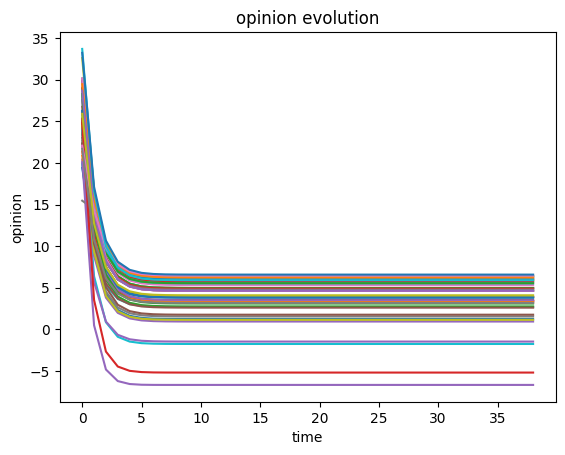

In [25]:
time_grid = range(len(xs))

for state in range(51):
    plt.plot(time_grid, [xs[t][state, 0] for t in time_grid])

plt.xlabel("time")
plt.ylabel("opinion")
plt.title("opinion evolution")
plt.show()

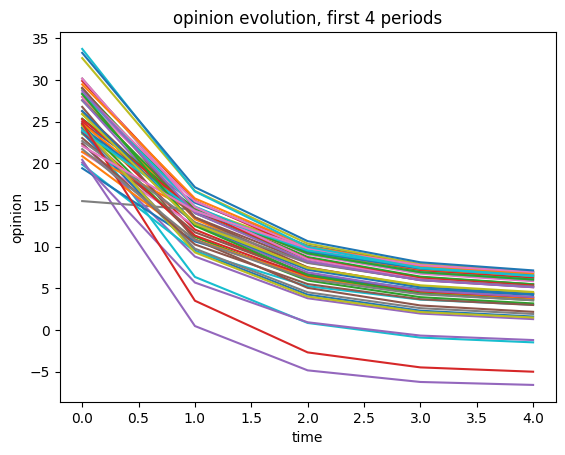

In [26]:
time_grid_short = range(5)
for state in range(51):
    plt.plot(time_grid_short, [xs[t][state, 0] for t in time_grid_short])

plt.xlabel("time")
plt.ylabel("opinion")
plt.title("opinion evolution, first 4 periods")
plt.show()

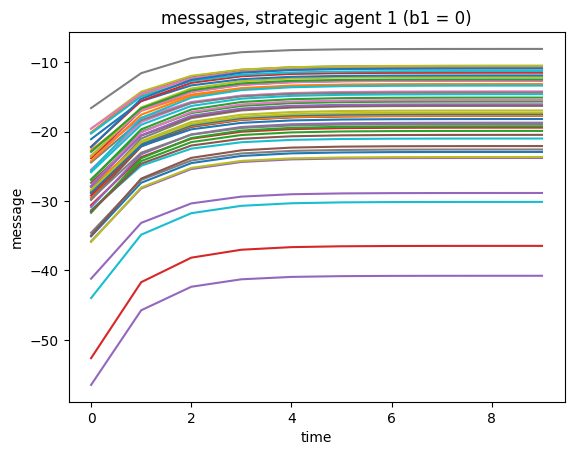

In [27]:
time_grid = range(10)
for state in range(51):
    plt.plot(time_grid, [rs[0][t][state, 0] for t in time_grid])

plt.xlabel("time")
plt.ylabel("message")
plt.title("messages, strategic agent 1 (b1 = 0)")
plt.show()

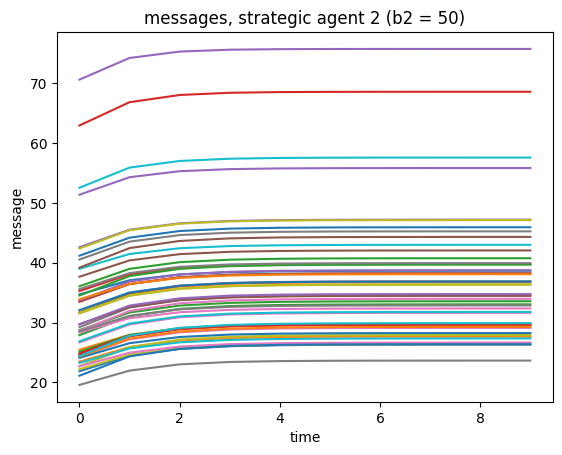

In [28]:
time_grid = range(10)
for state in range(51):
    plt.plot(time_grid, [rs[1][t][state, 0] for t in time_grid])

plt.xlabel("time")
plt.ylabel("message")
plt.title("messages, strategic agent 2 (b2 = 50)")
plt.show()

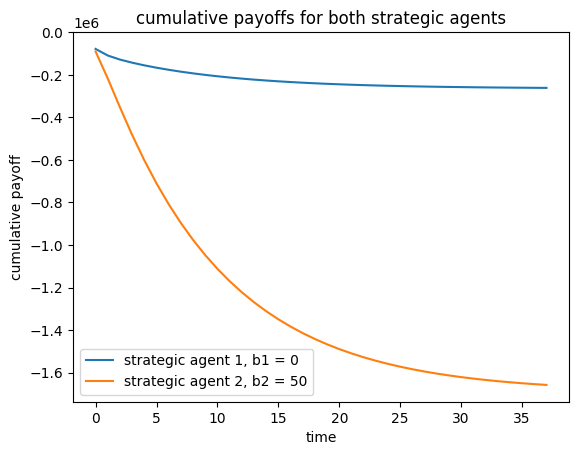

In [29]:
plt.plot(range(len(payoffs[0])), payoffs[0], label = "strategic agent 1, b1 = 0")
plt.plot(range(len(payoffs[1])), payoffs[1], label = "strategic agent 2, b2 = 50")
plt.xlabel("time")
plt.ylabel("cumulative payoff")
plt.title("cumulative payoffs for both strategic agents")
plt.legend()
plt.show()

### NOTE: The labels on the above plot's y-axis should be multiplied by $10^6$ to be interpreted.

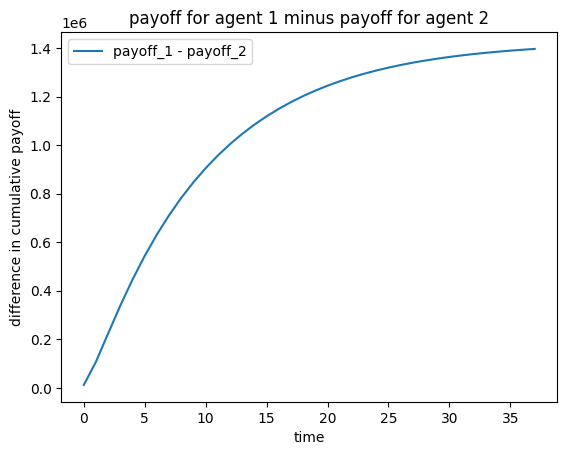

In [30]:
plt.plot(range(len(payoffs[0])), [payoffs[0][i] - payoffs[1][i] for i in range(len(payoffs[0]))], label = "payoff_1 - payoff_2")
plt.xlabel("time")
plt.ylabel("difference in cumulative payoff")
plt.legend()
plt.title("payoff for agent 1 minus payoff for agent 2")
plt.show()

### NOTE: The labels on the above plot's y-axis should be multiplied by $10^6$ to be interpreted.

In [31]:
# OPINIONS
for i, opinion_vec in enumerate(xs):
    print(f"t = {i}:", opinion_vec.T)

t = 0: [[24.83 27.95 28.93 25.04 20.41 23.02 21.35 15.46 23.52 24.26 23.67 21.37
  27.53 29.87 22.39 29.06 27.95 30.16 25.9  19.85 19.4  24.72 24.59 23.85
  27.57 26.22 28.45 24.11 32.61 28.35 24.29 20.85 25.35 25.28 20.08 26.76
  30.14 22.67 24.49 23.9  26.28 29.46 28.29 24.77 28.69 22.33 22.07 21.7
  25.9  33.71 33.24]]
t = 1: [[15.26488631 13.28929593 14.69751416 12.04290298  0.47526902 11.71774735
  12.50945203 14.43905601 14.65060744  6.36472209  9.50608558 14.10250502
  14.01498363 15.4881788   8.81236431 13.51351375 14.75629504 14.61394896
  12.86913424  9.41046266 10.6279633  14.10171411 11.16852263 11.3280774
  12.62051529 13.50352525 15.44758872  9.75411228 16.6710779  14.80908209
  14.17564541 10.8671046  14.54412982 14.35886024  5.68900223 10.84604831
  14.74792469 12.90872341  9.30370381 14.30207376 12.66423668 15.77275421
  12.50305175  3.51100452 14.02952289 10.25485746 14.27179132 10.78363377
  12.72887013 16.61949766 17.12030351]]
t = 2: [[10.11606789  7.50380413  8.75

In [32]:
# MESSAGES
for i in range(len(rs[0])):
    print(f"t = {i}:")
    print("  strategic agent 1:", rs[0][i].T)
    print("  strategic agent 2:", rs[1][i].T)
    print()

t = 0:
  strategic agent 1: [[-20.18491034 -29.49880726 -26.94539421 -29.19533258 -56.49232745
  -28.875205   -23.56845313 -16.61362826 -19.60018057 -43.97825917
  -35.09789217 -20.13503404 -26.88891317 -23.83737717 -35.80831769
  -29.82805316 -25.46942212 -28.63811182 -28.45667464 -31.30011711
  -27.99034748 -22.68699387 -31.45106888 -30.60548498 -30.85957975
  -27.37092416 -23.46641249 -34.57852347 -23.56895501 -25.84228966
  -21.09540175 -27.86766641 -22.9280296  -22.18317592 -41.1894144
  -34.95328532 -27.82942002 -24.44370866 -35.89652072 -20.2721345
  -28.80067352 -24.2483695  -31.70428425 -52.64007348 -27.86695887
  -31.50535936 -19.56494053 -29.70441597 -28.41314199 -25.67034475
  -22.2717285 ]]
  strategic agent 2: [[21.87894987 31.68796527 27.90428654 33.47052333 70.5879343  33.62161481
  28.35795546 19.59015581 22.19923082 52.52882857 41.16841125 23.46546018
  28.74386847 24.6080005  42.59122391 31.69123607 26.69224511 29.23777474
  31.52087156 38.98610617 34.71243011 25.473

In [33]:
# CUMULATIVE PAYOFFS
print("        strategic agent 1  strategic agent 2")
for i in range(len(payoffs[0])):
    print(f"t = {i}:", payoffs[0][i], payoffs[1][i])

        strategic agent 1  strategic agent 2
t = 0: -78167.13946742911 -90123.22336484064
t = 1: -109201.69063772421 -217128.41292761537
t = 2: -128164.85728293294 -352523.43299556326
t = 3: -142853.93062001225 -482295.0927878901
t = 4: -155368.43747802454 -601840.6238293668
t = 5: -166409.94255187578 -710353.9405349154
t = 6: -176276.303497886 -808319.3334457679
t = 7: -185133.1773069608 -896586.8759633792
t = 8: -193097.01737392615 -976059.5299088818
t = 9: -200262.1180114535 -1047595.1551274036
t = 10: -206709.9554329628 -1111980.4940998286
t = 11: -212512.76885011885 -1169928.3448578871
t = 12: -217735.22442315667 -1222081.7435922106
t = 13: -222435.41011525286 -1269019.9083627937
t = 14: -226665.56951326807 -1311264.2902948037
t = 15: -230472.71052027974 -1349284.2447079597
t = 16: -233899.1366493001 -1383502.2070647194
t = 17: -236982.919919056 -1414298.3742586384
t = 18: -239758.32478377988 -1442014.925073068
t = 19: -242256.18913730682 -1466959.8209137153
t = 20: -244504.267047